In [ ]:
!mkdir data ; ls -a data

In [1]:
import numpy as np
from torch.nn.functional import interpolate
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import models

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import os
import json



In [2]:
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
#from keras.utils import np_utils

num_classes = 10
input_shape = (28, 28, 1)

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#X_train = np.expand_dims(X_train, -1)
#X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [3]:
X_tr = torch.from_numpy(X_train)
X_tr = interpolate(X_tr,scale_factor=0.572).permute(0, 2, 1)
X_tr = interpolate(X_tr,scale_factor=0.572).permute(0, 2, 1)
X_train = X_tr

X_tr = torch.from_numpy(X_test)
X_tr = interpolate(X_tr,scale_factor=0.572).permute(0, 2, 1)
X_tr = interpolate(X_tr,scale_factor=0.572).permute(0, 2, 1)
X_test = X_tr

X_train.shape

/home/ubuntu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([60000, 16, 16])

In [4]:
from sklearn.datasets import dump_svmlight_file
from scipy.sparse import csr_matrix

dump_svmlight_file(X_train.reshape(60000,1,-1).squeeze(),y_train,"./data/fmnist")
dump_svmlight_file(X_test.reshape(10000,1,-1).squeeze(),y_test,"./data/fmnist.t")

In [11]:
!ls -al ./data

total 605016
drwxrwxr-x  2 ubuntu ubuntu      4096 Jul  4 16:53 .
drwxr-xr-x 20 ubuntu ubuntu      4096 Jul  4 17:13 ..
-rw-rw-r--  1 ubuntu ubuntu 530679097 Jul  4 17:14 fmnist
-rw-rw-r--  1 ubuntu ubuntu  88837973 Jul  4 17:15 fmnist.t


# Check

[9. 0. 0. ... 3. 0. 5.]


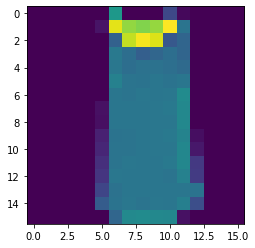

In [5]:
# maintained by rajivak@utexas.edu
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.metrics.pairwise import rbf_kernel


# class to load and handle data
class Data:
    X = None # n * d
    y = None # n
    gamma = None
    kernel  = None # n* n

    def __init__(self):
        pass

    # only to perform cross validation for picking gamma
    def splittraintest(self, testpercent):
        ntest = int(np.shape(self.X)[0] * testpercent/100.0)
        testindices = np.random.choice(np.shape(self.X)[0], ntest, replace=False)
        self.testX = self.X[testindices, :]
        self.testy = self.y[testindices]
        trainindices = np.setdiff1d(np.arange(np.shape(self.X)[0]), testindices)
        self.X = self.X[trainindices,:]
        self.y = self.y[trainindices]


    def subset(self, i):
        return np.where(y==i)[0]

    def load_data(self, X, y, gamma=None, docalkernel=False, savefile=None, testfile=None, dobin=False):
      self.X = X
      if dobin:
          bins = [-1.0, -0.67, -0.33, 0, 0.33, 0.67, 1.0]
          # bins = [-1.0, 0, 1.0]
          binned  = np.digitize(self.X, bins )
          self.X=np.array([bins[binned[i, j] - 1] for i in range(np.shape(self.X)[0]) for j in range(np.shape(self.X)[1])]).reshape(np.shape(self.X))

      self.y = y
      if testfile is not None:
          dat2 = load_svmlight_file(testfile)
          self.testX = dat2[0].todense()
          if dobin:
              bins = [-1.0, -0.67, -0.33, 0, 0.33, 0.67, 1.0]
              binned = np.digitize(self.testX, bins)
              self.testX = np.array([bins[binned[i, j] - 1] for i in range(np.shape(self.testX)[0]) for j in range(np.shape(self.testX)[1])]).reshape(np.shape(self.testX))

          self.testy = dat2[1]
      # print(np.shape(self.X))

      self.gamma = gamma
      self.kernel = rbf_kernel(self.X, gamma=gamma)

    def load_svmlight(self, filename, gamma=None, docalkernel=False, savefile=None, testfile=None, dobin=False):
        data = load_svmlight_file(filename)
        self.load_data(data[0].todense(), data[1], gamma, docalkernel, savefile, testfile, dobin)

    def calculate_kernel(self, g=None):
        if g is None:
            if self.gamma is None:
                print("gamma not provided!")
                exit(1)
            else:
                self.kernel = rbf_kernel(self.X, gamma=self.gamma)
        else:
            self.kernel = rbf_kernel(self.X, gamma=g)

    # only calculate distance within class. across class, distance = 0
    def calculate_kernel_individual(self, g=None):
        touseg = g
        if touseg is None:
            touseg = self.gamma
        if touseg is None:
            print("gamma not provided!")
            exit(1)
        self.kernel = np.zeros((np.shape(self.X)[0], np.shape(self.X)[0]) )
        sortind = np.argsort(self.y)
        self.X = self.X[sortind, :]
        self.y = self.y[sortind]

        for i in np.arange(10):
#            j = i+1
            j = i
            ind = np.where(self.y == i)[0]
            startind = np.min(ind)
            endind = np.max(ind)+1
            self.kernel[startind:endind, startind:endind ] = rbf_kernel(self.X[startind:endind, :], gamma=self.gamma)


    def loadstate(self,filename):
        temp = np.load(filename)
        self.X = temp['X']
        self.y = temp['y']
        self.gamma = temp['gamma']
        self.kernel = temp['kernel']

    def setgamma(self, newgamma):
        if self.kernel is not None:
            temp = np.log(self.kernel)
            temp = temp * newgamma/self.gamma
            self.kernel = np.exp(temp)
        self.gamma = newgamma
        if self.kernel is None:
            self.calculate_kernel()

    def savestate(self, outpfile):
        np.savez(file=outpfile, X=self.X, y=self.y, gamma=self.gamma, kernel=self.kernel)

    def rbf(v1,v2):
        dd = v1 - v2
        res = - self.gamma * np.dot(dd,dd)
        return math.exp(res)

    def getsim(self, i, j):
        if kernel is not None:
            return self.kernel[i,j]
        else:
            return self.rbf(X[i,:], X[j,:])


if __name__ == "__main__":
    import matplotlib.pyplot as plt
    file = 'data/fmnist'
    data=load_svmlight_file(file)
    X = data[0].todense()
    print(data[1])
    plt.imshow(X[2,:].reshape((16,16)))
    plt.show()


# PC

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
# from mpi4py import MPI
import sys
import math


##############################################################################################################################
# function to select criticisms
# ARGS:
# K: Kernel matrix
# selectedprotos: prototypes already selected
# m : number of criticisms to be selected
# reg: regularizer type.
# is_K_sparse:  True means K is the pre-computed  csc sparse matrix? False means it is a dense matrix.
# RETURNS: indices selected as criticisms
##############################################################################################################################
def select_criticism_regularized(K, selectedprotos, m, reg='logdet', is_K_sparse=True):

    n = np.shape(K)[0]
    if reg in ['None','logdet','iterative']:
        pass
    else:
        print("wrong regularizer :" + reg)
        exit(1)
    options = dict()

    selected = np.array([], dtype=int)
    candidates2 = np.setdiff1d(range(n), selectedprotos)
    inverse_of_prev_selected = None  # should be a matrix

    if is_K_sparse:
        colsum = np.array(K.sum(0)).ravel()/n
    else:
        colsum = np.sum(K, axis=0)/n

    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(candidates2, selected)

        s1array = colsum[candidates]

        temp = K[selectedprotos, :][:, candidates]
        if is_K_sparse:
            s2array = temp.sum(0)
        else:
            s2array = np.sum(temp, axis=0)

        s2array = s2array / (len(selectedprotos))

        s1array = np.abs(s1array - s2array)
        if reg == 'logdet':
            if inverse_of_prev_selected is not None: # first call has been made already
                temp = K[selected, :][:, candidates]
                if is_K_sparse:
                    temp2 = temp.transpose().dot(inverse_of_prev_selected)
                    regularizer = temp.transpose().multiply(temp2)
                    regcolsum = regularizer.sum(1).ravel()# np.sum(regularizer, axis=0)
                    regularizer = np.abs(K.diagonal()[candidates] - regcolsum)

                else:
                    # hadamard product
                    temp2 = np.array(np.dot(inverse_of_prev_selected, temp))
                    regularizer = temp2 * temp
                    regcolsum = np.sum(regularizer, axis=0)
                    regularizer = np.log(np.abs(np.diagonal(K)[candidates] - regcolsum))
                s1array = s1array + regularizer
            else:
                if is_K_sparse:
                    s1array = s1array - np.log(np.abs(K.diagonal()[candidates]))
                else:
                    s1array = s1array - np.log(np.abs(np.diagonal(K)[candidates]))
        argmax = candidates[np.argmax(s1array)]
        maxx = np.max(s1array)

        selected = np.append(selected, argmax)
        if reg == 'logdet':
            KK = K[selected,:][:,selected]
            if is_K_sparse:
                KK = KK.todense()

            inverse_of_prev_selected = np.linalg.inv(KK) # shortcut
        if reg == 'iterative':
            selectedprotos = np.append(selectedprotos, argmax)

    return selected

##############################################################################################################################
# Function choose m of all rows by MMD as per kernelfunc
# ARGS:
# K : kernel matrix
# candidate_indices : array of potential choices for selections, returned values are chosen from these  indices
# m: number of selections to be made
# is_K_sparse:  True means K is the pre-computed  csc sparse matrix? False means it is a dense matrix.
# RETURNS: subset of candidate_indices which are selected as prototypes
##############################################################################################################################

def greedy_select_protos(K, candidate_indices, m, is_K_sparse=False):

    if len(candidate_indices) != np.shape(K)[0]:
        K = K[:,candidate_indices][candidate_indices,:]

    n = len(candidate_indices)

    # colsum = np.array(K.sum(0)).ravel() # same as rowsum
    if is_K_sparse:
        colsum = 2*np.array(K.sum(0)).ravel() / n
    else:
        colsum = 2*np.sum(K, axis=0) / n

    selected = np.array([], dtype=int)
    value = np.array([])
    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)

        s1array = colsum[candidates]
        if len(selected) > 0:
            temp = K[selected, :][:, candidates]
            if is_K_sparse:
                # s2array = temp.sum(0) *2
                s2array = temp.sum(0) * 2 + K.diagonal()[candidates]

            else:
                s2array = np.sum(temp, axis=0) *2 + np.diagonal(K)[candidates]

            s2array = s2array/(len(selected) + 1)

            s1array = s1array - s2array

        else:
            if is_K_sparse:
                s1array = s1array - (np.abs(K.diagonal()[candidates]))
            else:
                s1array = s1array - (np.abs(np.diagonal(K)[candidates]))

        argmax = candidates[np.argmax(s1array)]
        # print("max %f" %np.max(s1array))

        selected = np.append(selected, argmax)
        # value = np.append(value,maxx)
        KK = K[selected, :][:, selected]
        if is_K_sparse:
            KK = KK.todense()

        inverse_of_prev_selected = np.linalg.inv(KK)  # shortcut

    return candidate_indices[selected]

In [7]:
# maintained by rajivak@utexas.edu
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# simple class to build 1NN classifier and classify using it
class Classifier:
    model=None

    def __init__(self):
        pass

    def build_model(self, trainX, trainy):
        print("building model using %d points " %len(trainy))
        self.model = KNeighborsClassifier(n_neighbors=1)
        self.model.fit(trainX, trainy)

    def classify(self, testX, testy):

        print("classifying %d points " %len(testy))
        predy = self.model.predict(testX)

        ncorrect = np.sum(predy == testy)
        return 1.0 - ncorrect/(len(predy) + 0.0)

In [8]:
# maintained by rajivak@utexas.edu
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os

import numpy as np

def format_numsel(numsel):
    ss = ''
    for i,j in enumerate(numsel):
        ss = ss + " %d:%d " %(i,j)
    return ss

def get_train_testindices(n, ntest, seed):
    np.random.seed(seed)
    testindices = np.random.choice(n,ntest,replace=False)
    trainindices = np.setdiff1d( range(n), testindices)
    return trainindices, testindices

def exit(str):
    print(str)
    exit(1)


def dir_exists(filename):
    """Creates the directory of a file if the directory does not exist.
    
    Raises:
      IOError: If the directory could not be created (and the directory does not
          exist). This may be due to for instance permissions issues or a race
          condition in which the directory is created right before makdirs runs.
    """
    dir = os.path.dirname(filename)
    if not os.path.exists(dir):
        os.makedirs(dir)

Running Kernel type : local 
0 41
1 40
2 41
3 42
4 41
5 41
6 41
7 41
8 41
9 0
number of images being printed 410
counter 1 
counter 2 
counter 3 
counter 4 
counter 5 
counter 6 
counter 7 
counter 8 
counter 9 
counter 10 
counter 11 
0 18
1 55
2 27
3 35
4 56
5 55
6 12
7 66
8 22
9 0
number of images being printed 400
counter 1 
counter 2 
counter 3 
counter 4 
counter 5 
counter 6 
counter 7 
counter 8 
counter 9 
counter 10 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


counter 11 
prototypes =  [47473  9056 23634  4556 34300 25135 59002 13119 36546 53465 21054  9601
 56544 47894 24287 17776 30465  3855 37519 52633 22999  9517 25326 16431
 56503 42317  4060 50036 30377 36308 19899 13094 28063  3928  9047 57775
 39696 43066 32760 49915 22956 17758 56154 28409  6308  1324 40265 44374
 53360 34568 22138 13485  4973 36748 55566  7255 24256 42659 51911 33700
 22296 39030  1137 43056  6146 15213 56706 49653 28893 33209 37267 19470
 57130 42352  4158 10179 24116 15639 51414 30301 19663 37553  5465 56749
 42257  6234 50289 28718 13657 33207 40672  9602 23044  3342 55414 46348
 52631 28206 30237 12251 37163 19968 26097  6911 43762 12341 57976  3929
 50202 30347 36905 29515 23446 11850 12964 44418 35804  2682 56902 49431
 37071 25788  8192 23970  5341 13559 42474 53784 35699 58871 23226 37663
 28344  7968 43213  4431 13923 30535 59676 39541 52660 19152  6287 25066
 30716 45128 13335  1031 10831 51634 58650 23657 40503 28195 15191 34425
 43444 55008  3588  7134 

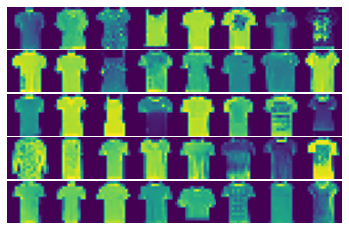

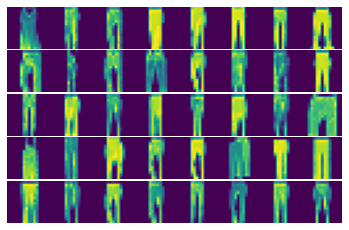

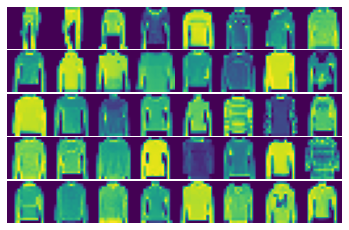

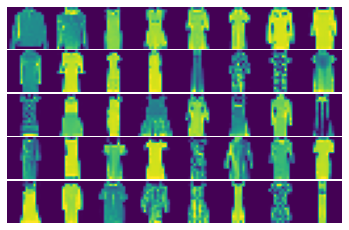

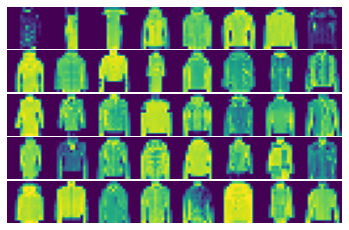

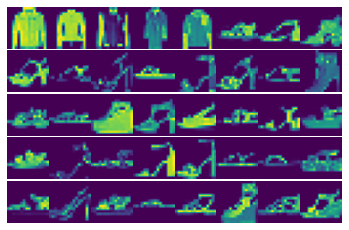

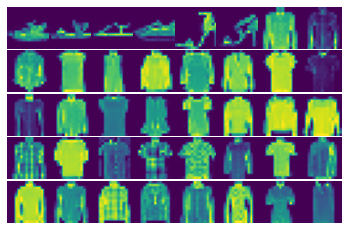

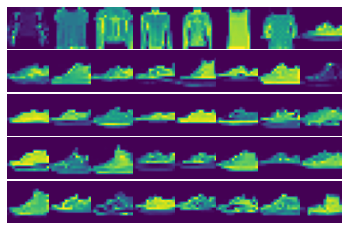

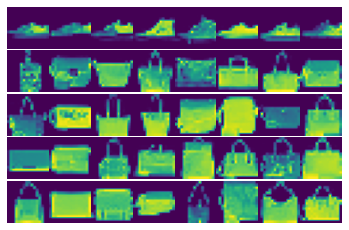

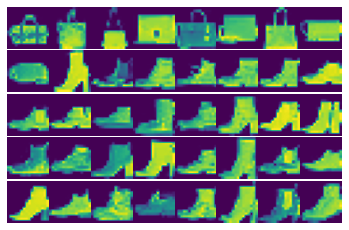

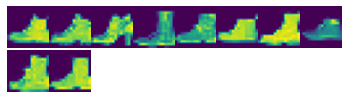

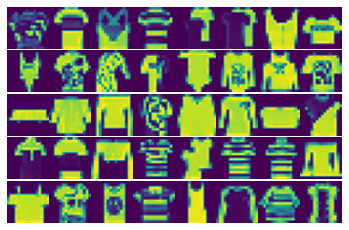

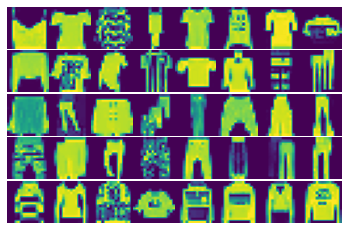

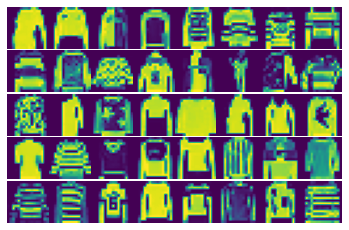

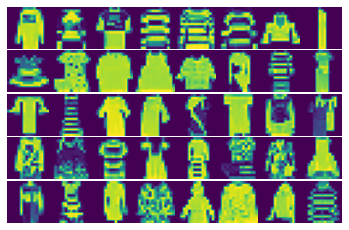

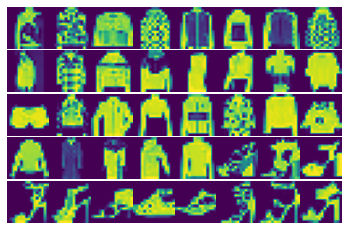

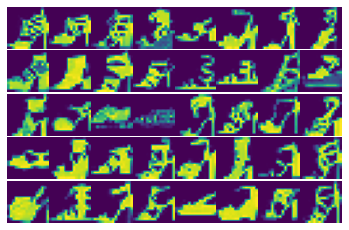

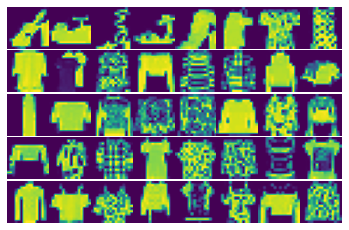

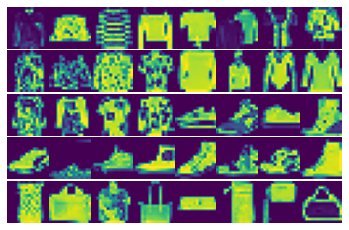

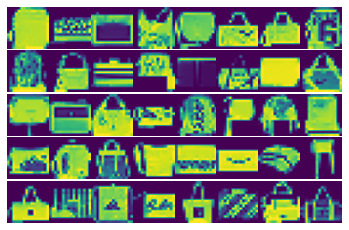

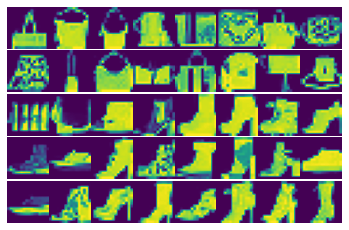

<Figure size 432x288 with 0 Axes>

In [9]:
# maintained by rajivak@utexas.edu
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import argparse
import os
#from data import Data
#from mmd import select_criticism_regularized, greedy_select_protos
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import gridspec
#from classify import Classifier
#from mpi4py import MPI
#import Helper


DATA_DIRECTORY = os.path.join(os.getcwd(), 'data')


##############################################################################################################################
# plotter function to draw the selected prototypes/criticisms
# ARGS :
# xx : the matrix of selected pictures, each row is the representation of the digit picture
# y : true classification of the picture, only used to print in order
# fileprefix: path prefix
# printselectionnumbers : if True, number of selected digits of each type are also outputted in the output file.
# RETURNS: nothing
##############################################################################################################################
def plotfigs2(xx, selectedy, fileprefix=None, printselectionnumbers = False):
    num_selected = np.array([0] * 10)
    for ii in range(10):
        num_selected[ii] = len(np.where(selectedy == (ii + 1))[0])
        print(ii, num_selected[ii])

    totm = np.shape(xx)[0]
    print("number of images being printed %d" %totm)
    perpic_m = 40
    begin_at = 0
    counter = 0
    perrow = 8

    while counter < int(totm/perpic_m) + 1:

        counter += 1
        print("counter %d " % counter)

        offset = 0
        if begin_at == 0:
            offset = 5 # for text about number of protos/crits of each type
        if not printselectionnumbers:
            offset = 0

        # m=m+offset  # for num_selected
        gs = gridspec.GridSpec(int(perpic_m/perrow+offset/perrow), perrow, wspace=0.0, hspace=0.0)
        fig = plt.figure()

        if begin_at == 0 and printselectionnumbers:
            ax=fig.add_subplot(gs[0,:])
            ax.text(0.1,0.5,format_numsel(num_selected))
            ax.axis('off')

        endd = begin_at + offset+ perpic_m
        if endd-offset > totm:
            endd = totm +offset
        for i in np.array(range(begin_at + offset, endd)):
            ax = fig.add_subplot(gs[i - begin_at])
            #ax.imshow(xx[i - offset, :].reshape((16, 16)), cmap="Greys_r")
            ax.imshow(xx[i - offset, :].reshape((16, 16)))
            ax.axis('off')

        file = fileprefix+str(counter) + '.png'
        if file is not None:
            # print("saving file")
            plt.savefig(file , dpi=2000)

        begin_at += perpic_m



##############################################################################################################################
# this function makes selects prototypes/criticisms and outputs the respective pictures. Also does 1-NN classification test
# ARGS:
# filename: the path to usps file
# gamma: parameter for the kernel exp( - gamma * \| x1 - x2 \|_2 )
# ktype: kernel type, 0 for global, 1 for local
# outfig: path where selected prototype pictures are outputted, can be None when outputting of pictures is skipped
# critoutfig: path where selected criticism pictures are outputted, can be None
# testfile : path to the test usps.t
# RETURNS: returns indices of  selected prototypes, criticisms and the built data structure that contains the loaded usps dataset
##############################################################################################################################
def run(filename,  gamma, m, k, ktype, outfig, critoutfig,testfile):

    digitsdat = Data()
    digitsdat.load_svmlight(filename, gamma=gamma, docalkernel=False, savefile=None, testfile=testfile, dobin=False)

    if ktype == 0:
        digitsdat.calculate_kernel()
        print("Running Kernel type : global ")
    else:
        digitsdat.calculate_kernel_individual()
        print("Running Kernel type : local ")



    # selected = greedy_parallel(digitsdat.kernel, m)
    # print(np.sort(selected))
    selected = greedy_select_protos(digitsdat.kernel, np.array(range(np.shape(digitsdat.kernel)[0])), m)
    # print(np.sort(selected))
        # critselected = select_criticism(digitsdat.kernel, selected, k)
    selectedy = digitsdat.y[selected]
    sortedindx = np.argsort(selectedy)
    critselected= None

    if outfig is not None:
        plotfigs2(digitsdat.X[selected[sortedindx], :], selectedy[sortedindx], outfig)


    if k > 0:
        critselected = select_criticism_regularized(digitsdat.kernel, selected, k, is_K_sparse=False, reg='logdet')
        reg = 'logdet'
        critselectedy = digitsdat.y[critselected]
        critsortedindx = np.argsort(critselectedy)

        if critoutfig is not None:
            plotfigs2(digitsdat.X[critselected[critsortedindx], :], critselectedy[critsortedindx], critoutfig+reg)

    print("prototypes = ",selected,"  criticisms = ",critselected)
    return selected, critselected, digitsdat

#########################################################################################################################
# build a 1 NN classifier based on selected prototypes, test it against testfile
# ARGS:
# digitsdat : Data() structure already built. should also have built the kernels and loaded the test file as well.
# selected : the indices of selected prototypes, in order of their selection (the order is important for all_test_k to be viable.
# all_test_m : array of number of prototypes to be used to build classifier. Since the selections are greedy, one can select for 5000 prototypes,
#     and test for num_prototypes = 10, 100, 1000, 4000, etc.
##############################################################################################################################
def test_1NN(digitsdat, selected, all_test_m):

    for testm in all_test_m:

        classifier = Classifier()
        classifier.build_model(digitsdat.X[selected[0:testm], :], digitsdat.y[ selected[0:testm]])
        print("m=%d error=%f" % ( testm, classifier.classify(digitsdat.testX, digitsdat.testy)))

        # uncomment for stats on how many protos were selected for each type of digit.
        # num_selected = np.array([0] * 10)

        # for ii in range(10):
        #   num_selected[ii] = len(np.where(selectedy == (ii + 1))[0])
        #   print(ii, num_selected[ii])


#########################################################################################################################
#########################################################################################################################
#########################################################################################################################
# start here
def main(
      data_prefix,
      output_prefix,
      gamma,
      m,
      alltestm,
      kerneltype,
      do_output_pics):
    ioff()

    outfig = None
    critoutfig = None

    k = 400 # number of criticisms

    if do_output_pics == 1:
        outfig = os.path.join(output_prefix, 'images/%d/protos' % m)
        critoutfig = os.path.join(output_prefix, 'images/%d/crit' % m)

        dir_exists(outfig)

    selected, critselected, digitsdat = run(
            os.path.join(data_prefix, 'fmnist'),
            gamma,
            m,
            k,
            kerneltype,
            outfig,
            critoutfig,
            os.path.join(data_prefix, 'fmnist.t'))

    test_1NN(digitsdat, selected, alltestm)

    print("...done")


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument(
#         "--data_directory",
#         type=str,
#         default=DATA_DIRECTORY,
#         help="The directory that contains data such as the usps file.")
#     parser.add_argument(
#         "--output_directory",
#         type=str,
#         default="/tmp",
#         help="The directory in which to output data.")
#     FLAGS, unparsed = parser.parse_known_args()

data_prefix = 'data' #FLAGS.data_directory
output_prefix = '' #os.path.join(FLAGS.output_directory, "data")
gamma = 0.026 # kernel parameter, obtained after cross validation

#m= 4433 # total number of prototypes to select
#alltestm =  np.array([4433,  3772, 3135, 2493, 1930, 1484, 1145, 960, 828, 715, 643, 584, 492, 410, 329, 286, 219, 185, 130, 110]) # test using these number of prototypes

m = 410  # total number of prototypes to select
alltestm = np.array(
    [410, 329, 286, 219, 185, 130,
      110])  # test using these number of prototypes

do_output_pics = 1
kernel_type = 1 # 1 for local, 0 for global

main(data_prefix, output_prefix, gamma, m, alltestm, kernel_type, do_output_pics)

